In [27]:
import re
import math
import warnings
import tqdm
import matplotlib
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.pyplot import MultipleLocator
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")


%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

In [28]:
# ! conda install tqdm 
# ! conda install pandas 
# ! conda install numpy 
# ! conda install scipy 
# ! conda install matplotlib 
# ! conda install xgboost 
# ! conda install -c conda-forge sklearn-contrib-lightning
# ! conda install -c conda-forge tpot-imblearn
# ! conda install lightgbm
# ! conda install openpyxl

In [29]:
data1=pd.read_excel('/root/2023-NPMCM-main/表1-患者列表及临床信息.xlsx')
data2=pd.read_excel('/root/2023-NPMCM-main/表2-患者影像信息血肿及水肿的体积及位置.xlsx')
data3=pd.read_excel('/root/2023-NPMCM-main/表3-患者影像信息血肿及水肿的形状及灰度分布.xlsx')
data4=pd.read_excel('/root/2023-NPMCM-main/表4-答案文件.xlsx')
data5=pd.read_excel('1b数据.xlsx').drop(['ID'], axis=1)

data1.rename(columns={data1.columns[0]: "ID"}, inplace=True)
data2.rename(columns={data2.columns[0]: "ID"}, inplace=True)

data_f_1=pd.read_excel('/root/2023-NPMCM-main/附表1-检索表格-流水号vs时间.xlsx')
data_kz=pd.read_excel('/root/2023-NPMCM-main/q11/扩张及时间.xlsx')

In [30]:
# 转换独热编码
xueya_list = []
for i in data5['血压']:
    y1 = i.split('/')[0]
    y2 = i.split('/')[1]
    if int(y1) > 139 or int(y1) < 90:
        status_i = 0
    elif int(y2) > 89 or int(y2) < 60:
        status_i = 0
    else:
        status_i = 1
    xueya_list.append(status_i)
data5['血压'] = np.array(xueya_list)
data5['性别_男'] = data5['性别'].apply(lambda x: 1 if x == '男' else 0)
data5['性别_女'] = data5['性别'].apply(lambda x: 1 if x == '女' else 0)
data5 = data5.drop(columns=['性别'])
x = data5['年龄'].values
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x.reshape(-1, 1))
binarizer = Binarizer(threshold=0.5)
x_binarized = binarizer.fit_transform(x_normalized)
data5['年龄'] = x_binarized
data5 = data5.drop(['流水号'], axis = 1)

In [31]:
# 归一化
# 创建 MinMaxScaler 对象
scaler = MinMaxScaler()
# 选择要归一化的列（除了 '年龄' 列之外的所有列）
columns_to_normalize = [col for col in data5.columns if col != '性别']
# 使用 MinMaxScaler 对所选列进行归一化
data5[columns_to_normalize] = scaler.fit_transform(data5[columns_to_normalize])

In [32]:
train = data5[:100]
label = data_kz['是否扩张'].values[:100]
predict = data5[100:]

In [33]:
# 定义参数网格
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'learning_rate': [0.01, 0.1, 0.2],
}

param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
}

param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 100), (50, 100)],
    'activation': ['relu', 'tanh'],
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'], 
}

In [34]:
sm = SMOTE(random_state=0)
xres, yres = sm.fit_resample(train.values, label)
xtrain, xvalid, ytrain, yvalid = train_test_split(train.values,label,random_state=50,test_size=0.2)
xtrain_res, xvalid_res, ytrain_res, yvalid_res = train_test_split(xres,yres,random_state=50,test_size=0.2)

# 采样前
def function_before(model, param_grid, cv_values=[5], n_jobs=16):
    best_auc = 0
    best_cv = None
    best_model = None
    best_params = None

    for cv in cv_values:
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_jobs=n_jobs)
        grid_search.fit(train.values, label)

        if grid_search.best_score_ > best_auc:
            best_model = grid_search.best_estimator_
            best_auc = grid_search.best_score_
            best_params = grid_search.best_params_
            best_cv = cv

    if best_model is None:
        raise ValueError("No model was trained successfully.")

    acc = round(cross_val_score(best_model, train.values, label, cv=best_cv, scoring='accuracy').mean(), 2)
    recall = round(cross_val_score(best_model, train.values, label, cv=best_cv, scoring='recall').mean(), 2)
    precision = round(cross_val_score(best_model, train.values, label, cv=best_cv, scoring='precision').mean(), 2)
    f1 = round(cross_val_score(best_model, train.values, label, cv=best_cv, scoring='f1').mean(), 2)

    result_dict = {
        'best_model': best_model,
        'best_auc': round(best_auc, 2),
        'best_params': best_params,
        'acc': acc,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'best_cv': best_cv
    }

    return result_dict

cv_values = [5, 10]
best_results_rf = function_before(RandomForestClassifier(random_state=100), param_grid_rf, cv_values)
best_results_lgbm = function_before(LGBMClassifier(random_state=100), param_grid_lgbm, cv_values)
best_results_xgb = function_before(XGBClassifier(random_state=100), param_grid_xgb, cv_values)
best_results_svc = function_before(SVC(probability=True, random_state=100), param_grid_svc, cv_values)
best_results_mlp = function_before(MLPClassifier(random_state=100), param_grid_mlp, cv_values)
best_results_lr = function_before(LogisticRegression(random_state=100), param_grid_lr, cv_values)

model0 = best_results_rf['best_model']
model1 = best_results_lgbm['best_model']
model2 = best_results_xgb['best_model']
model3 = best_results_svc['best_model']
model4 = best_results_mlp['best_model']
model5 = best_results_lr['best_model']

model0.fit(xtrain,ytrain)
model1.fit(xtrain,ytrain)
model2.fit(xtrain,ytrain)
model3.fit(xtrain,ytrain)
model4.fit(xtrain,ytrain)
model5.fit(xtrain,ytrain)

LogisticRegression(C=1, random_state=100)

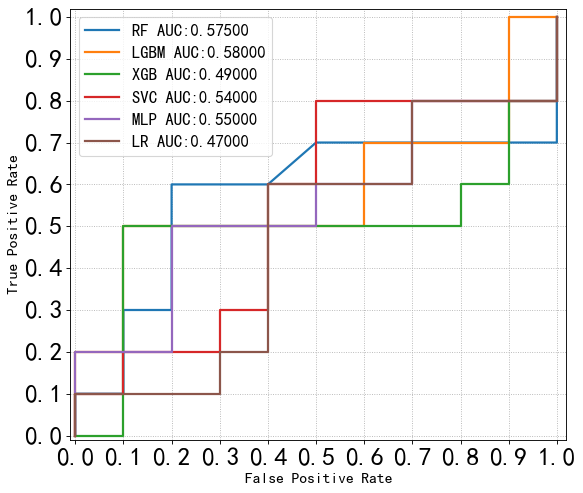

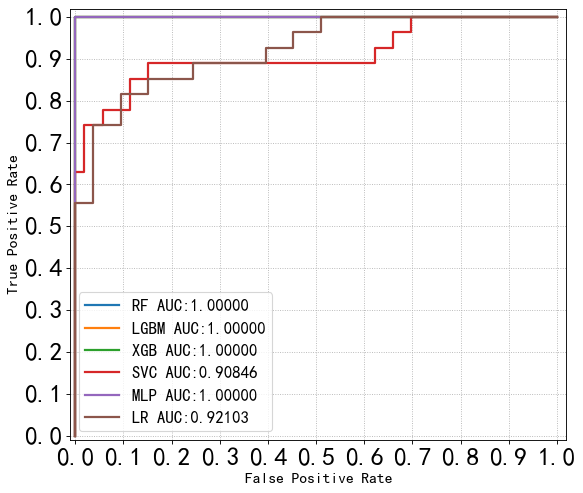

In [35]:

def f(model_list,name_list,types='train'):
    plt.figure(figsize=(8, 7), dpi=80, facecolor='w')    # dpi:每英寸长度的像素点数；facecolor 背景颜色
    plt.xlim((-0.01, 1.02))  # x,y 轴刻度的范围
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))  #绘制刻度
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    if types == 'test':
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xvalid)[:,1]
            fpr, tpr, _ = metrics.roc_curve(yvalid, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.5f' % auc)  # 绘制AUC 曲线
    else:
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xtrain)[:,1]
            fpr, tpr, _ = metrics.roc_curve(ytrain, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.5f' % auc)  # 绘制AUC 曲线
    plt.legend(loc='best',fontsize=15)    # 设置显示标签的位置
    plt.xlabel('False Positive Rate', fontsize=14)   #绘制x,y 坐标轴对应的标签
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.tick_params(labelsize=23)

    plt.grid(b=True, ls=':')  # 绘制网格作为底板;b是否显示网格线；ls表示line style
    plt.savefig(f'q1_roc_auc({types}(采样前)).png',dpi=500)
    plt.show()

f([model0, model1, model2, model3, model4, model5], ['RF', 'LGBM', 'XGB', 'SVC', 'MLP', 'LR'], 'test')
f([model0, model1, model2, model3, model4, model5], ['RF', 'LGBM', 'XGB', 'SVC', 'MLP', 'LR'], 'train')

In [36]:
# 采样后
def function_after(model, param_grid, cv_values=[5], n_jobs=16):
    best_auc = 0
    best_cv = None
    best_model = None
    best_params = None

    for cv in cv_values:
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_jobs=n_jobs)
        grid_search.fit(xres, yres)
        
        if grid_search.best_score_ > best_auc:
            best_model = grid_search.best_estimator_
            best_auc = grid_search.best_score_
            best_params = grid_search.best_params_
            best_cv = cv

    if best_model is None:
        raise ValueError("No model was trained successfully.")

    acc = round(cross_val_score(best_model, xres, yres, cv=best_cv, scoring='accuracy').mean(), 2)
    recall = round(cross_val_score(best_model, xres, yres, cv=best_cv, scoring='recall').mean(), 2)
    precision = round(cross_val_score(best_model, xres, yres, cv=best_cv, scoring='precision').mean(), 2)
    f1 = round(cross_val_score(best_model, xres, yres, cv=best_cv, scoring='f1').mean(), 2)
    
    result_dict = {
        'best_model': best_model,
        'best_auc': round(best_auc, 2),
        'best_params': best_params,
        'acc': acc,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'best_cv': best_cv
    }
    
    return result_dict

cv_values = [5, 10]
best_results_rf = function_after(RandomForestClassifier(random_state=100), param_grid_rf, cv_values)
best_results_lgbm = function_after(LGBMClassifier(random_state=100), param_grid_lgbm, cv_values)
best_results_xgb = function_after(XGBClassifier(random_state=100), param_grid_xgb, cv_values)
best_results_svc = function_after(SVC(probability=True, random_state=100), param_grid_svc, cv_values)
best_results_mlp = function_after(MLPClassifier(random_state=100), param_grid_mlp, cv_values)
best_results_lr = function_after(LogisticRegression(random_state=100), param_grid_lr, cv_values)

model0 = best_results_rf['best_model']
model1 = best_results_lgbm['best_model']
model2 = best_results_xgb['best_model']
model3 = best_results_svc['best_model']
model4 = best_results_mlp['best_model']
model5 = best_results_lr['best_model']

model0.fit(xtrain_res,ytrain_res)
model1.fit(xtrain_res,ytrain_res)
model2.fit(xtrain_res,ytrain_res)
model3.fit(xtrain_res,ytrain_res)
model4.fit(xtrain_res,ytrain_res)
model5.fit(xtrain_res,ytrain_res)

LogisticRegression(C=1, random_state=100)

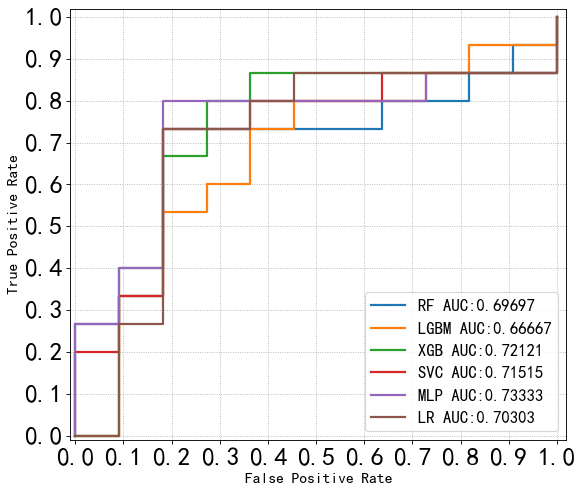

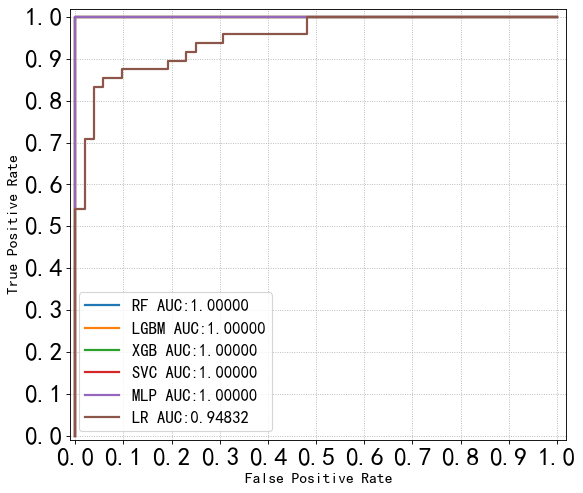

In [37]:
def f(model_list,name_list,types='train'):
    plt.figure(figsize=(8, 7), dpi=80, facecolor='w')    # dpi:每英寸长度的像素点数；facecolor 背景颜色
    plt.xlim((-0.01, 1.02))  # x,y 轴刻度的范围
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))  #绘制刻度
    plt.yticks(np.arange(0, 1.1, 0.1))
    
    if types == 'test':
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xvalid_res)[:,1]
            fpr, tpr, _ = metrics.roc_curve(yvalid_res, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.5f' % auc)  # 绘制AUC 曲线
    else:
        for model,name in zip(model_list,name_list):
            ytest_prob = model.predict_proba(xtrain_res)[:,1]
            fpr, tpr, _ = metrics.roc_curve(ytrain_res, ytest_prob)
            auc = metrics.auc(fpr, tpr)
            plt.plot(fpr, tpr, '-', lw=2, label=f'{name} AUC:%.5f' % auc)  # 绘制AUC 曲线
    plt.legend(loc='best',fontsize=15)    # 设置显示标签的位置
    plt.xlabel('False Positive Rate', fontsize=14)   #绘制x,y 坐标轴对应的标签
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.tick_params(labelsize=23)

    plt.grid(b=True, ls=':')  # 绘制网格作为底板;b是否显示网格线；ls表示line style
    plt.savefig(f'q1_roc_roc_auc({types}（采样后）).png',dpi=500)
    plt.show()

f([model0, model1, model2, model3, model4, model5], ['RF', 'LGBM', 'XGB', 'SVC', 'MLP', 'LR'], 'test')
f([model0, model1, model2, model3, model4, model5], ['RF', 'LGBM', 'XGB', 'SVC', 'MLP', 'LR'], 'train')

In [38]:
xgb_model = best_results_xgb['best_model']
xgb_model.fit(xres,yres)
xgb_model_result = [round(i,4) for i in xgb_model.predict_proba(data5.values)[:,1]]

In [39]:
xgb_model_result = pd.DataFrame({'扩张概率':xgb_model_result})
xgb_model_result.to_excel('q12扩张概率.xlsx',index=False)

In [40]:
# 'name':data1['ID'].values,
xgb_model_result

,扩张概率
0,0.0199
1,0.0090
2,0.9487
3,0.0107
4,0.9870
...,...
155,0.0050
156,0.7390
157,0.1967
158,0.2657
